<a href="https://colab.research.google.com/github/NITIN9694/TensorFlow-Learning/blob/main/06_Transfer_Learning_2_(Fine_Tuning)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Transfer Learning with tesnsroflow part 2 : Fine Tuning

in the previous notebook , we covered transfer learning feature extraction now we cover new kind of tranfer learning :fine truning


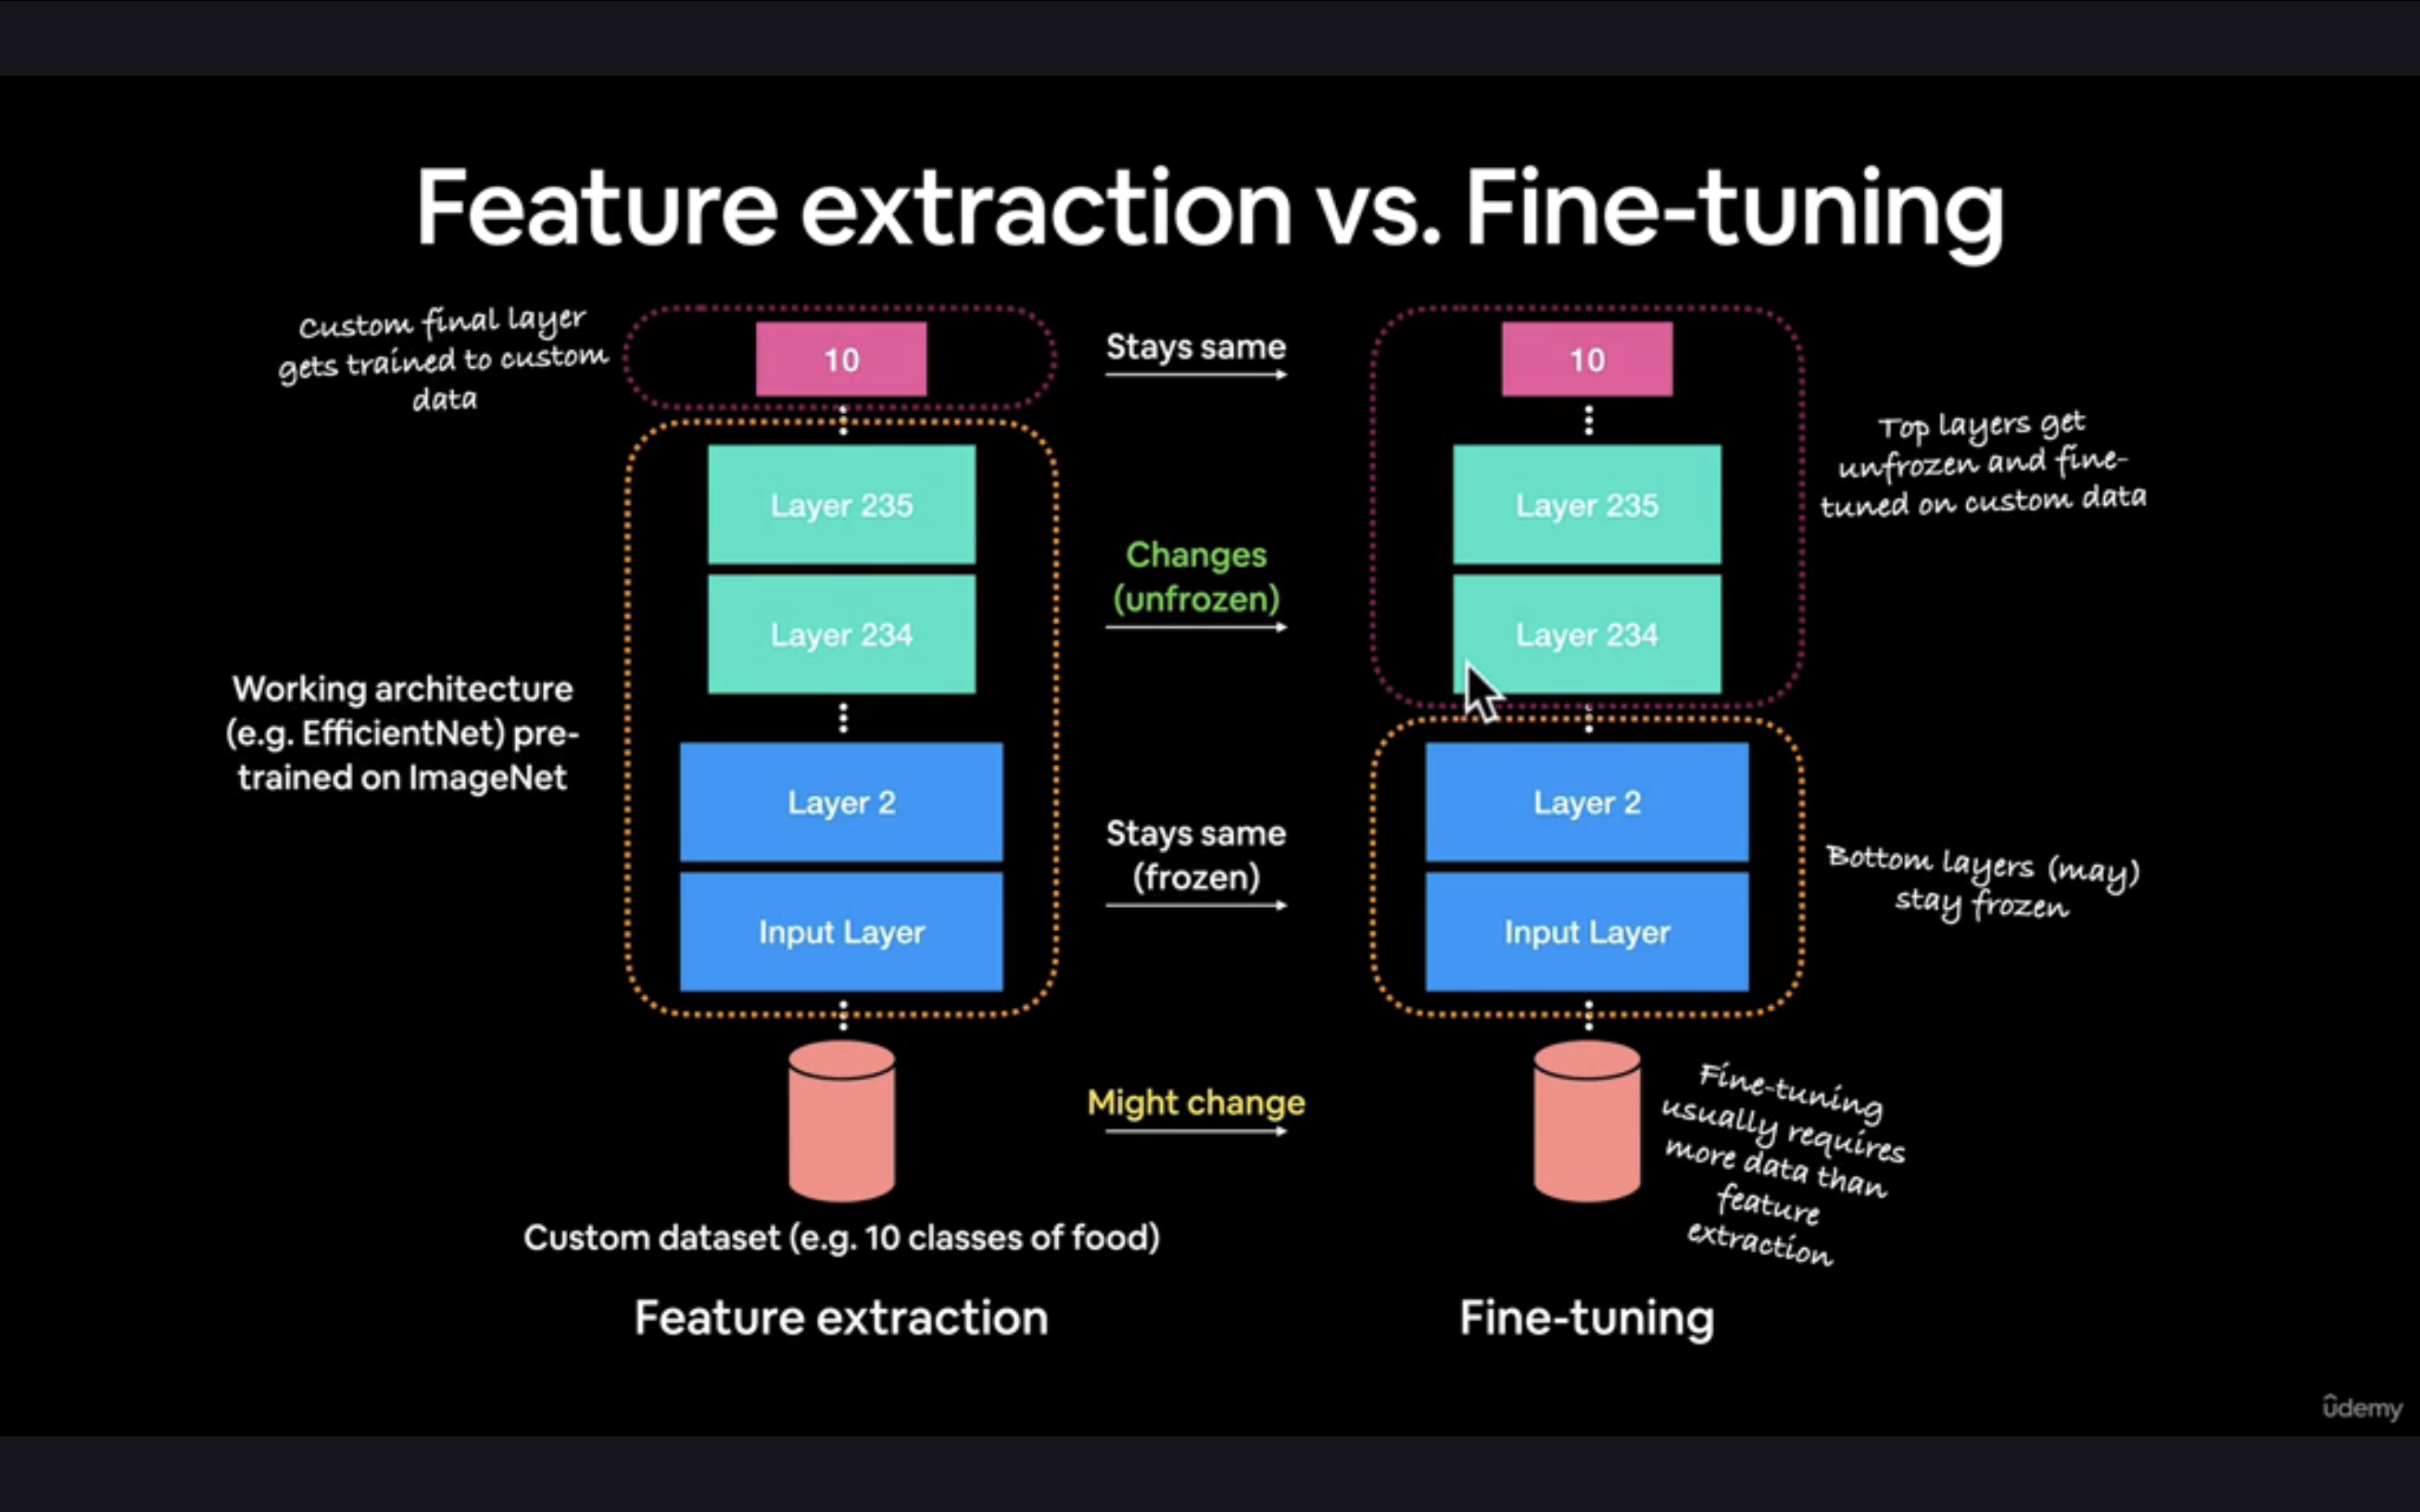

In [1]:
#check which GPU we'r using
!nvidia-smi

Mon Sep  8 18:27:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-09-08 18:27:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-09-08 18:27:54 (82.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves , unzip_data , walk_through_dir

### Let's Get some data
This time we are going to see how we can trained model with keras.application.data for our own problem ( recognizing image of food  ).

In [4]:
#Get 10% of training data of 10 classes of Food101

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2025-09-08 18:27:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   147MB/s    in 1.1s    

2025-09-08 18:27:59 (147 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
#check how many images are subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/trai

In [6]:
#creating train and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"


In [7]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
 directory = train_dir,
 image_size =  IMG_SIZE,
 batch_size =  BATCH_SIZE )

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
  directory = test_dir,
  image_size = IMG_SIZE,
  batch_size = BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
#checkout class name of dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

###Model 0: Building a transfer learning module using keras funcation API

The Sequential API is straight-forwoard, it runs layers in Sequential order.
But the funcational api gives us more flexibilty with our model

In [9]:
#1. Create base model with tf.keras.application
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

#2. Freeze the base model
base_model.trainable = False

#3. Create input into model
input = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

#4.pass the input layers
x = base_model(input)

#5. Average pool the output of the model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

#6. Create the output activation layer
output = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

#7. Combine input with the output into model

model_0 = tf.keras.Model(input,output)


#8. compile model
model_0.compile(
    loss = "sparse_categorical_crossentropy", # Changed to sparse_categorical_crossentropy
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

#9. fit the model
model_0_histroy = model_0.fit(
    train_data_10_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data_10_percent,
    validation_steps = int(0.15 * len(test_data_10_percent)),

)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.2753 - loss: 2.0957 - val_accuracy: 0.7415 - val_loss: 1.3270
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.7447 - loss: 1.1686 - val_accuracy: 0.8068 - val_loss: 0.9072
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.8249 - loss: 0.7981 - val_accuracy: 0.8182 - val_loss: 0.7443
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.8351 - loss: 0.6549 - val_accuracy: 0.8153 - val_loss: 0.7008
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.8851 - loss: 0.5593 - val_accuracy: 0.8153 - val_loss: 0.6342


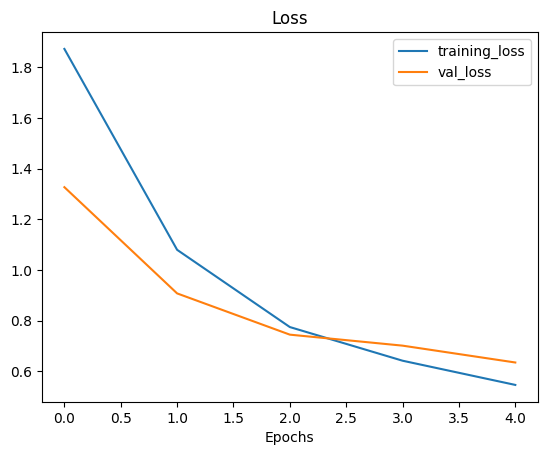

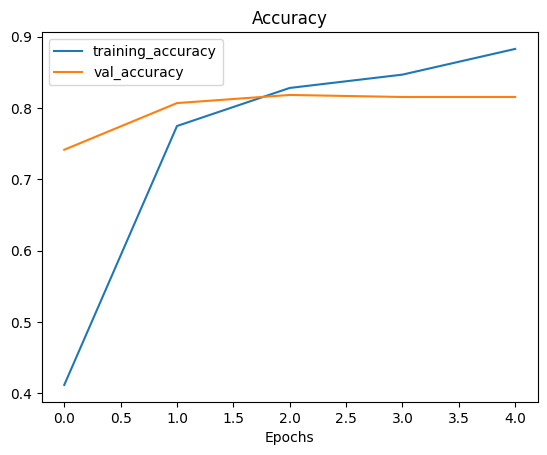

In [10]:
plot_loss_curves(model_0_histroy)

In [11]:
model_0.evaluate(test_data_10_percent)

79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step - accuracy: 0.8545 - loss: 0.5746


[0.5516768097877502, 0.8644000291824341]

In [12]:
#check the layer in our model
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_layer
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [13]:
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          7 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, None,      │          0 │ normalization[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, None,      │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ stem_conv_pad[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 32)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [14]:
#summary of whole model
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,088,003 (15.59 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 25,622 (100.09 KB)

##Geting Feature Vector from trained model

Let's demonstrate the global average pooling 2D layers....

we have tensor after goes through base_model of shape (None,7,7,1280).
But we pass through the GlobalAvargePool2D, it turn into (None,1280).

Let's use similar shaped tensor of (1,4,4,3) and then pass GlobalAvarage Pooling2D



In [15]:
#Define the input shape
input_shape = (1,4,4,3)


#create random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor :\n {input_tensor}\n")

#pass the random tensor through a global average pooling 2d layers
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"Gloabal Avrage :\n {global_average_pooled_tensor}\n")

#check the shape

print(f"shape is input {input_tensor.shape}")
print(f"shape is  Global Average{global_average_pooled_tensor.shape}")

Random input tensor :
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

Gloabal Avrage :
 [[-0.09368646 -0.45840448 -0.2885598 ]]

shape is input (1, 4, 4, 3)
shape is  Global Average(1, 3)


In [16]:
#lets replicate the globaAveragePool2d layer
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Runnig a series of transfer learning experiments

we've seen the incredible results transfer learning can get only with 10% of the training  data,  but how does it go with 1% of the training data.. how about we set up a bunch of expriments to find out:

1. `model_1` - use feature extraction transfer learning with 1 % of the training data with data augmentation.

2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation

3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation

4. `model_4`- use fine-tuning tranfer learning on 100% of the training data with data augmentation

> 🔑 **Note** throughout all expriments the same test dataset wil be used to evaluate our model... this ensures consistency across evaluation metrics.

##Geting  and preprocessing data for model_1


In [17]:
#Download and unzip data - preprocessed from Food 101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


--2025-09-08 18:30:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   224MB/s    in 0.7s    

2025-09-08 18:30:46 (224 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [18]:
unzip_data("10_food_classes_10_percent.zip")

In [19]:
#create trainig and test dirs

train_dir_1_percent = "10_food_classes_10_percent/train"
test_dir_1_percent = "10_food_classes_10_percent/test"

In [20]:
#how many images
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/trai

In [21]:
#setup data loaders
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE
                                                                           )


test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_1_percent,
    label_mode = "categorical",
    image_size= IMG_SIZE,
    batch_size = BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#Adding data augmentation right into model

> Add blockquote



To add data augmentation right into our model we can use the layers inside:

*  tf.keras.layers.experimental.preprocessing()




In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Create data agumentation stage with horizontal fliping , rotations , zooms
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2) ],
   name="data_agumentation"
)

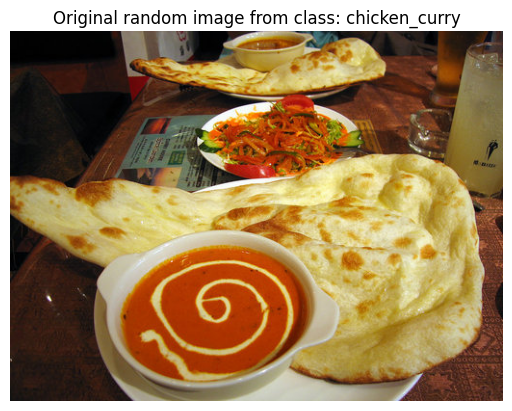

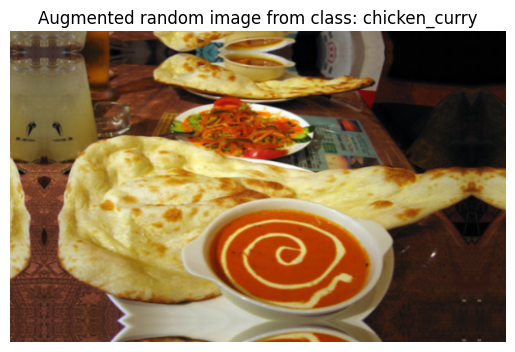

In [24]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_10_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Define input shape
input_shape = (224, 224, 3)

# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
], name="data_augmentation")

# Load base model with correct input shape
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
    input_shape=input_shape,
    weights='imagenet'
)

# Freeze base model
base_model.trainable = False

# Input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Apply data augmentation
x = data_augmentation(inputs)

# Pass through base model
x = base_model(x, training=False)

# Global average pooling
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Output layer
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Build the model
model_1 = models.Model(inputs, outputs)

# Compile the model
model_1.compile(
    loss="categorical_crossentropy",  # Changed to categorical_crossentropy
    optimizer=optimizers.Adam(),
    metrics=["accuracy"]
)

# Now you can fit the model
model_1_history = model_1.fit(
    train_data_1_percent,
    epochs=5,
    steps_per_epoch=len(train_data_1_percent),
    validation_data=test_data_1_percent,
    validation_steps=int(0.25 * len(test_data_1_percent)),
    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")]
)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20250908-183456
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 301ms/step - accuracy: 0.2233 - loss: 2.1975 - val_accuracy: 0.6908 - val_loss: 1.4165
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.6372 - loss: 1.3900 - val_accuracy: 0.7780 - val_loss: 0.9735
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.7695 - loss: 0.9570 - val_accuracy: 0.8158 - val_loss: 0.7690
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.8084 - loss: 0.8281 - val_accuracy: 0.8438 - val_loss: 0.6597
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.8460 - loss: 0.7216 - val_accuracy: 0.8553 - val_loss: 0.5953


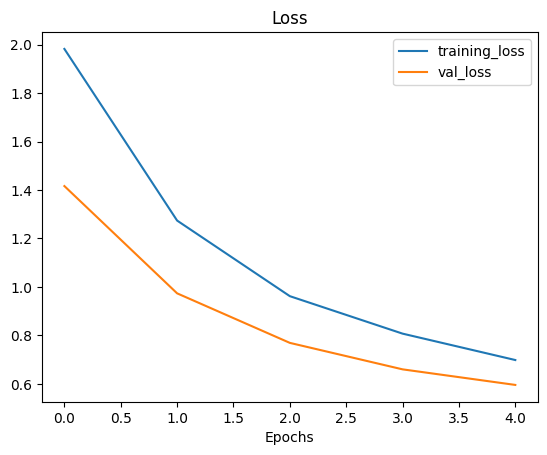

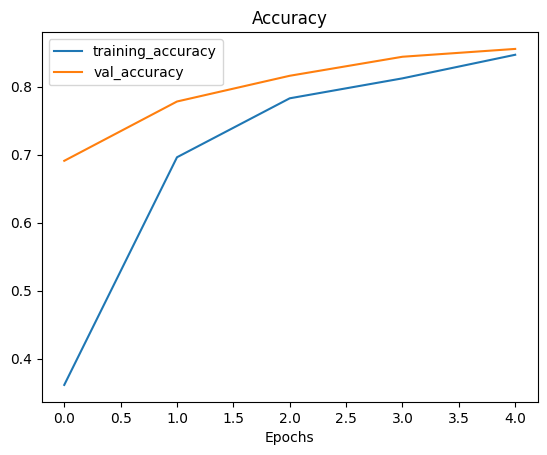

In [26]:
plot_loss_curves(model_1_history)

#FineTuning  an exiting model on 10% of the data

Note:- Fine tuning usually works best after training a feature exraction model for few epochs with large amount of custom data.

In [27]:
model_1.layers

[<InputLayer name=input_layer, built=True>,
 <Sequential name=data_augmentation, built=True>,
 <Functional name=efficientnetv2-b0, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling_layer, built=True>,
 <Dense name=output_layer, built=True>]

In [28]:
#are these layers trainbel?
for layers in model_1.layers:
  print(layers,layers.trainable)

<InputLayer name=input_layer, built=True> True
<Sequential name=data_augmentation, built=True> True
<Functional name=efficientnetv2-b0, built=True> False
<GlobalAveragePooling2D name=global_average_pooling_layer, built=True> True
<Dense name=output_layer, built=True> True


In [42]:
#to being fine-tuning, let's start by setting the last 10 layers of our base_model  = True

base_model.trainable = True

#freeze all layers expect last 10
for layer in base_model.layers[:-10]:
   layer.trainable = False

#Recompile
model_1.compile(loss = "categorical_crossentropy", # Changed to categorical_crossentropy
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), #fine tuning low your learning rate
                metrics = ["accuracy"] )

model_fintuning =   model_1.fit(
    train_data_10_percent ,epochs = 10,
    validation_data = test_data_10_percent,
    validation_steps = int(0.25 * len(test_data_10_percent)),
    initial_epoch = model_1_history.epoch [-1]
    )

Epoch 5/10


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 10)

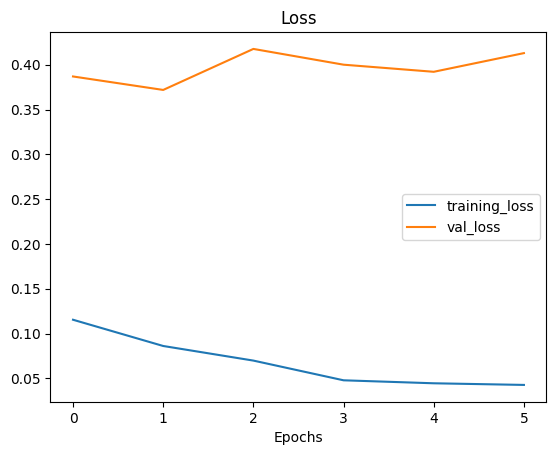

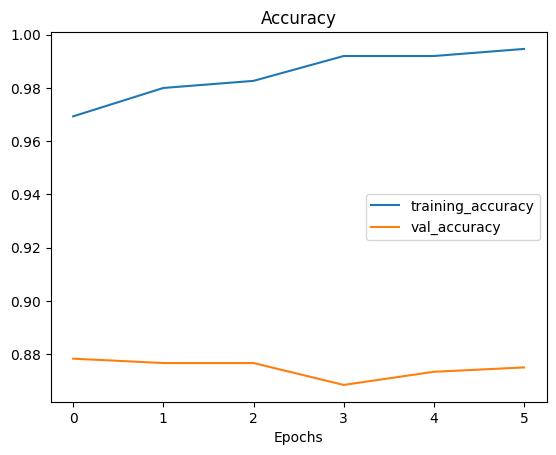

In [31]:
plot_loss_curves(model_fintuning)

In [32]:
model_1.evaluate(test_data_10_percent)

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.8847 - loss: 0.3880


[0.37550726532936096, 0.8884000182151794]

In [33]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.36133334040641785, 0.6959999799728394, 0.7826666831970215, 0.8119999766349792, 0.846666693687439, 0.9693333506584167, 0.9800000190734863, 0.9826666712760925, 0.9919999837875366, 0.9919999837875366, 0.9946666955947876]


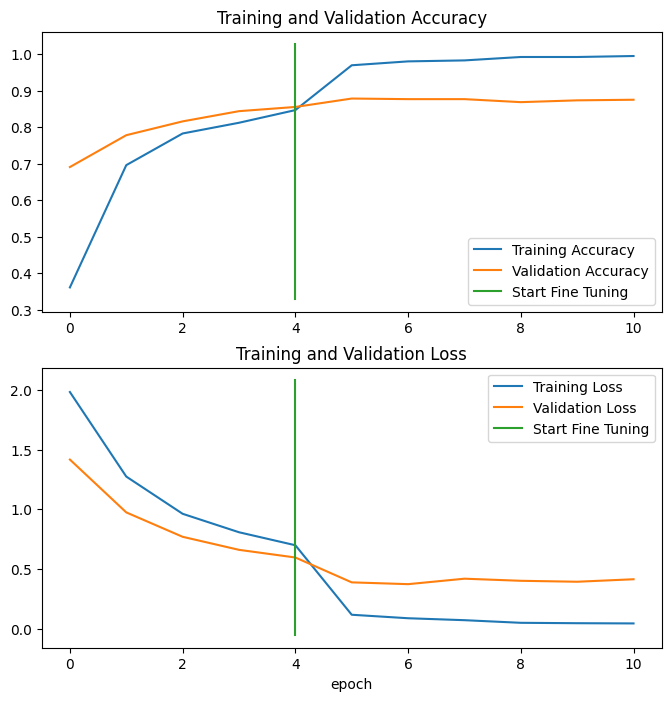

In [35]:

compare_historys(original_history=model_1_history,
                 new_history=model_fintuning,
                 initial_epochs=5)

#Model 4: Fine-tuning an existing model all of the data

We'll start by downloading the full version of our 10 food classes dataset.



In [34]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2025-09-08 18:40:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  65.3MB/s    in 7.9s    

2025-09-08 18:40:28 (62.5 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [36]:

# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Oh this is looking good. We've got 10x more images in of the training classes to work with.

The **test dataset is the same** we've been using for our previous experiments.

As it is now, our `model_1` has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction.

To demonstrate this, we'll first evaluate the current `model_1`.

In [41]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_1.evaluate(test_data_10_classes_full)

ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 10), output.shape=(None, 10)

### Creating a ModelCheckpoint callback

Our model is compiled and ready to be fit, so why haven't we fit it yet?

Well, for this experiment we're going to introduce a new callback, the `ModelCheckpoint` callback.

The [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback gives you the ability to save your model, as a whole in the [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format or the [weights (patterns) only](https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights) to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In fact, that's exactly what we're going to do.

But first, let's create a `ModelCheckpoint` callback. To do so, we have to specifcy a directory we'd like to save to.

In [ ]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

> 🤔 **Question:** What's the difference between saving the entire model (SavedModel format) and saving the weights only?

The [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format saves a model's architecture, weights and training configuration all in one folder. It makes it very easy to reload your model exactly how it is elsewhere. However, if you do not want to share all of these details with others, you may want to save and share the weights only (these will just be large tensors of non-human interpretable numbers). If disk space is an issue, saving the weights only is faster and takes up less space than saving the whole model.

Time to fit the model.

Because we're going to be fine-tuning it later, we'll create a variable `initial_epochs` and set it to 5 to use later.

We'll also add in our `checkpoint_callback` in our list of `callbacks`.

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_1.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data_10_classes_full,
                                          validation_steps=int(0.25 * len(test_data_10_classes_full)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])

Alright, the previous steps might seem quite confusing but all we've done is:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using `ModelCheckpoint` (**Model 2**).
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (**Model 3**).
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all (100%) of the data (**Model 4**).

The same steps as 2?

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.